[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Automated Dataset Annotation and Evaluation with Grounding DINO

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/IDEA-Research/GroundingDINO) [![arXiv](https://img.shields.io/badge/arXiv-2303.05499-b31b1b.svg)](https://arxiv.org/abs/2303.05499)

Grounding DINO can detect **arbitrary objects** with human inputs such as category names or referring expressions. The key solution of open-set object detection is introducing language to a closed-set detector DINO. for open-set concept generalization. If you want to learn more visit official GitHub [repository](https://github.com/IDEA-Research/GroundingDINO) and read the [paper](https://arxiv.org/abs/2303.05499).

![grounding dino figure](https://media.roboflow.com/notebooks/examples/grounding-dino-figure.png)

## Complementary Materials

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/grounding-dino-zero-shot-object-detection) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/cMa77r3YrDk)

We recommend that you follow along in this notebook while reading the blog post on Grounding DINO. We will talk about the advantages of Grounding DINO, analyze the model architecture, and provide real prompt examples.

![grounding dino](https://media.roboflow.com/notebooks/examples/grounding-dino.png)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- **Before you start** - Make sure you have access to the GPU
- **Install Grounding DINO** - Setup Python environment.
- **Download Example Data** - Download a few images that we will use in our experiments.
- **Load model**
- **Model Prompt Engineering Results** - Let's compare the prediction results we can get by running the Grounding DINO model in different modes, and what effect feature engineering has on the quality of the obtained results.
- **Utils Supporting Dataset Processing** - A couple of helper functions that, unfortunately, we have to write ourselves to facilitate the processing of COCO annotations.
- **Download Dataset from Roboflow** - In order to evaluate how Grounding DINO handles zero-shot detection on custom datasets, we need to have labeled data. To do this, we download the data set in `COCO` format from Roboflow. In order to give you even more fun, we have selected for you several data sets with different levels of difficulty. Grounding DINO obtains mAPs on them from `1.0` to almost `0.0`.
- **Single Image Human vs. Zero-Shot Annotation** - In this section, we compare the results of inference performed with Grounding DINO with manual annotations.
- **Dataset Evaluation** - In this section, we compare the results obtained with the Grounding DINO model and manual annotations at the whole-dataset level. We will also calculate key metrics like mAP and confusion matrix.
- **Dataset Auto Annotation** - Finally, how about putting Grounding DINO in front of a real test and using it to automatically annotate datasets.

## Let's begin!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon May 26 13:20:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 88%   64C    P0             65W /  170W |    2546MiB /  12288MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references


## Install Grounding DINO & additional dependencies

⚠️ Grounding DINO is still under heavy development.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In addition to Grounding DINO, we will install some additional packages:
- `roboflow` - To download and send datasets to cloud.
- `dataclasses-json` - To make it easier to process COCO JSON and load data from disk.
- `onemetric` - To compare the results of manual labeling with those obtained with Grounding DINO.

In [ ]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git

%cd /content/GroundingDINO/groundingdino/models/GroundingDINO/csrc/MsDeformAttn
!sed -i 's/value.type()/value.scalar_type()/g' ms_deform_attn_cuda.cu
!sed -i 's/value.scalar_type().is_cuda()/value.is_cuda()/g' ms_deform_attn_cuda.cu

%cd {HOME}/GroundingDINO

# we use latest Grounding DINO model API that is not official yet
!git checkout feature/more_compact_inference_api

!pip install -q -e .
!pip install -q roboflow dataclasses-json onemetric

In [ ]:
import os
import subprocess

# Hardcoded paths
REPO_DIR = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO"
CU_FILE = os.path.join(REPO_DIR, "groundingdino", "models", "GroundingDINO", "csrc", "MsDeformAttn", "ms_deform_attn_cuda.cu")

# Clone the repo if it doesn't exist
if not os.path.exists(REPO_DIR):
    subprocess.run([
        "git", "clone",
        "https://github.com/IDEA-Research/GroundingDINO.git",
        REPO_DIR
    ])

# Checkout specific branch
os.chdir(REPO_DIR)
subprocess.run(["git", "checkout", "feature/more_compact_inference_api"])

# Patch CUDA file for PyTorch compatibility (Windows/Linux safe)
if os.path.exists(CU_FILE):
    with open(CU_FILE, "r") as f:
        content = f.read()
    content = content.replace("value.type()", "value.scalar_type()")
    content = content.replace("value.scalar_type().is_cuda()", "value.is_cuda()")
    with open(CU_FILE, "w") as f:
        f.write(content)
    print("✅ CUDA file patched.")
else:
    print(f"❌ CUDA file not found at: {CU_FILE}")

# Make sure PyTorch is installed
try:
    import torch
    print("✅ PyTorch is installed.")
except ImportError:
    print("⚠️ PyTorch not found. Run:")
    print("pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")

# Install GroundingDINO and dependencies
subprocess.run(["pip", "install", "-e", REPO_DIR])
subprocess.run(["pip", "install", "roboflow", "dataclasses-json", "onemetric"])


✅ CUDA file patched.
✅ PyTorch is installed.


**NOTE:** Before we begin, let's still log the version of all the key libraries we will use.

In [4]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
roboflow: 1.1.64 ; supervision: 0.4.0


In [2]:
import torch
import roboflow
import supervision
import subprocess

# Check torch and CUDA versions
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1] if "+" in torch.__version__ else "CPU-only"
print("✅ torch:", TORCH_VERSION, "| cuda:", CUDA_VERSION)

# Try to detect NVCC (CUDA compiler)
try:
    result = subprocess.run(["nvcc", "--version"], capture_output=True, text=True)
    if result.returncode == 0:
        print("✅ nvcc found:\n", result.stdout.splitlines()[-1])
    else:
        print("⚠️ nvcc not found or not in PATH.")
except FileNotFoundError:
    print("⚠️ nvcc (CUDA compiler) not found on this system.")

# Print package versions
print("✅ roboflow:", roboflow.__version__)
print("✅ supervision:", supervision.__version__)

✅ torch: 2.5 | cuda: cu121
✅ nvcc found:
 Build cuda_12.9.r12.9/compiler.35813241_0
✅ roboflow: 1.1.64
✅ supervision: 0.25.1


**NOTE:** To run the Grounding DINO model we will need two things: a configuration file and a weights file. The first one is part of the repository we just cloned. The second one we need to download.

In [5]:
# confirm that configuration file exist

import os

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [3]:
import os

# Hardcoded HOME path
HOME = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO"

# Path to config
CONFIG_PATH = os.path.join(HOME, "groundingdino", "config", "GroundingDINO_SwinT_OGC.py")

print("Config path:", CONFIG_PATH)
print("Exists:", os.path.isfile(CONFIG_PATH))

Config path: C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\groundingdino\config\GroundingDINO_SwinT_OGC.py
Exists: True


In [6]:
# download weights file

%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights


In [4]:
import os
import urllib.request

# Hardcoded weights directory
weights_dir = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\weights"
os.makedirs(weights_dir, exist_ok=True)

# Path to the weights file
weights_url = "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"
weights_path = os.path.join(weights_dir, "groundingdino_swint_ogc.pth")

# Download if missing
if not os.path.exists(weights_path):
    print("⬇️ Downloading weights...")
    urllib.request.urlretrieve(weights_url, weights_path)
    print("✅ Download complete.")
else:
    print("✅ Weights already downloaded:", weights_path)

✅ Weights already downloaded: C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\weights\groundingdino_swint_ogc.pth


In [7]:
# confirm that weights file exist

import os

WEIGHTS_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/weights/groundingdino_swint_ogc.pth ; exist: True


In [5]:
import os

# Hardcoded path to the weights file
WEIGHTS_PATH = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\weights\groundingdino_swint_ogc.pth"

print("Weights path:", WEIGHTS_PATH)
print("Exists:", os.path.isfile(WEIGHTS_PATH))

Weights path: C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\weights\groundingdino_swint_ogc.pth
Exists: True


## Download Example Data

We download a few images that we will use in our experiments - feature engineering and automated data annotation.


In [8]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

/content
mkdir: cannot create directory ‘/content/data’: File exists
/content/data


In [6]:
import os
import urllib.request

# Hardcoded data directory
data_dir = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\data"
os.makedirs(data_dir, exist_ok=True)

# Image URLs to download
image_urls = [
    "https://media.roboflow.com/notebooks/examples/dog.jpeg",
    "https://media.roboflow.com/notebooks/examples/dog-2.jpeg",
    "https://media.roboflow.com/notebooks/examples/dog-3.jpeg",
    "https://media.roboflow.com/notebooks/examples/dog-4.jpeg"
]

# Download each image if not already downloaded
for url in image_urls:
    filename = os.path.basename(url)
    filepath = os.path.join(data_dir, filename)
    if not os.path.exists(filepath):
        print(f"⬇️ Downloading {filename}...")
        urllib.request.urlretrieve(url, filepath)
        print("✅ Done.")
    else:
        print(f"✅ Already downloaded: {filename}")

✅ Already downloaded: dog.jpeg
✅ Already downloaded: dog-2.jpeg
✅ Already downloaded: dog-3.jpeg
✅ Already downloaded: dog-4.jpeg


## Load model

In [9]:
!rm -f ~/.huggingface/token

from huggingface_hub import login
login("GRID_DINO_API_KEY") # Replace this

In [7]:
import os
from dotenv import load_dotenv
from huggingface_hub import login

# Hardcoded path to .env file
env_path = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.env"
load_dotenv(dotenv_path=env_path)

# Load token
token = os.getenv("GRIND_DINO_API_KEY")

if token:
    login(token)
    print("✅ Hugging Face login successful.")
else:
    print("❌ Token not found. Check GRIND_DINO_API_KEY in your .env file.")

✅ Hugging Face login successful.


In [10]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

/content/GroundingDINO


Importing from timm.models.layers is deprecated, please import via timm.layers
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
from groundingdino.util.inference import Model

# Hardcoded paths from previous cells
CONFIG_PATH = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\groundingdino\config\GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\weights\groundingdino_swint_ogc.pth"

# Initialize model on GPU
model = Model(
    model_config_path=CONFIG_PATH,
    model_checkpoint_path=WEIGHTS_PATH,
    device="cuda"
)

print("✅ Model initialized.")

final text_encoder_type: bert-base-uncased


✅ Model initialized.


In [9]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")

CUDA available: True
Device count: 1
Device name: NVIDIA GeForce RTX 3060


## Model Prompt Engineering Results

Let's compare the prediction results we can get by running the Grounding DINO model in different modes, and what effect feature engineering has on the quality of the obtained results

In [18]:
SOURCE_IMAGE_PATH = f"{HOME}/data/89.PNG"
CLASSES = ['pool']
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

In [10]:
import os

# Hardcoded HOME path
HOME = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN"

# Image path and detection parameters
SOURCE_IMAGE_PATH = os.path.join(HOME, "images", "89.PNG")
CLASSES = ['pool']
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

print("Image path:", SOURCE_IMAGE_PATH)
print("Exists:", os.path.isfile(SOURCE_IMAGE_PATH))

Image path: C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\images\89.PNG
Exists: True


### Caption Inference Mode
---
**NOTE:** Most flexible. You pass single prompt string as argument. Phrases returned by the model during prediction are treated as arbitrary strings and not as categories. For this reason, BoxAnnotator produces paint boxes in different colors even if the phrase assigned to the box is the same.

In [1]:
from groundingdino.models.GroundingDINO import ms_deform_attn
print("✅ CUDA extension loaded:", hasattr(ms_deform_attn, "_C"))

✅ CUDA extension loaded: True


c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.venv\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
from groundingdino.util.inference import Model

In [3]:
CONFIG_PATH = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\groundingdino\config\GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\weights\groundingdino_swint_ogc.pth"


from groundingdino.util.inference import Model

model = Model(
    model_config_path=CONFIG_PATH,
    model_checkpoint_path=WEIGHTS_PATH,
    device="cuda"
)

print("✅ Model initialized.")

c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.venv\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


c:\users\sabio\documents\github\pool-detection-cnn\groundingdino\groundingdino\util\inference.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(mo

✅ Model initialized.


c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.venv\lib\site-packages\transformers\modeling_utils.py:1613: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.venv\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\.venv\lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
c:\users\sabio\documents\github\pool-detection-cnn\groundingdino\gr

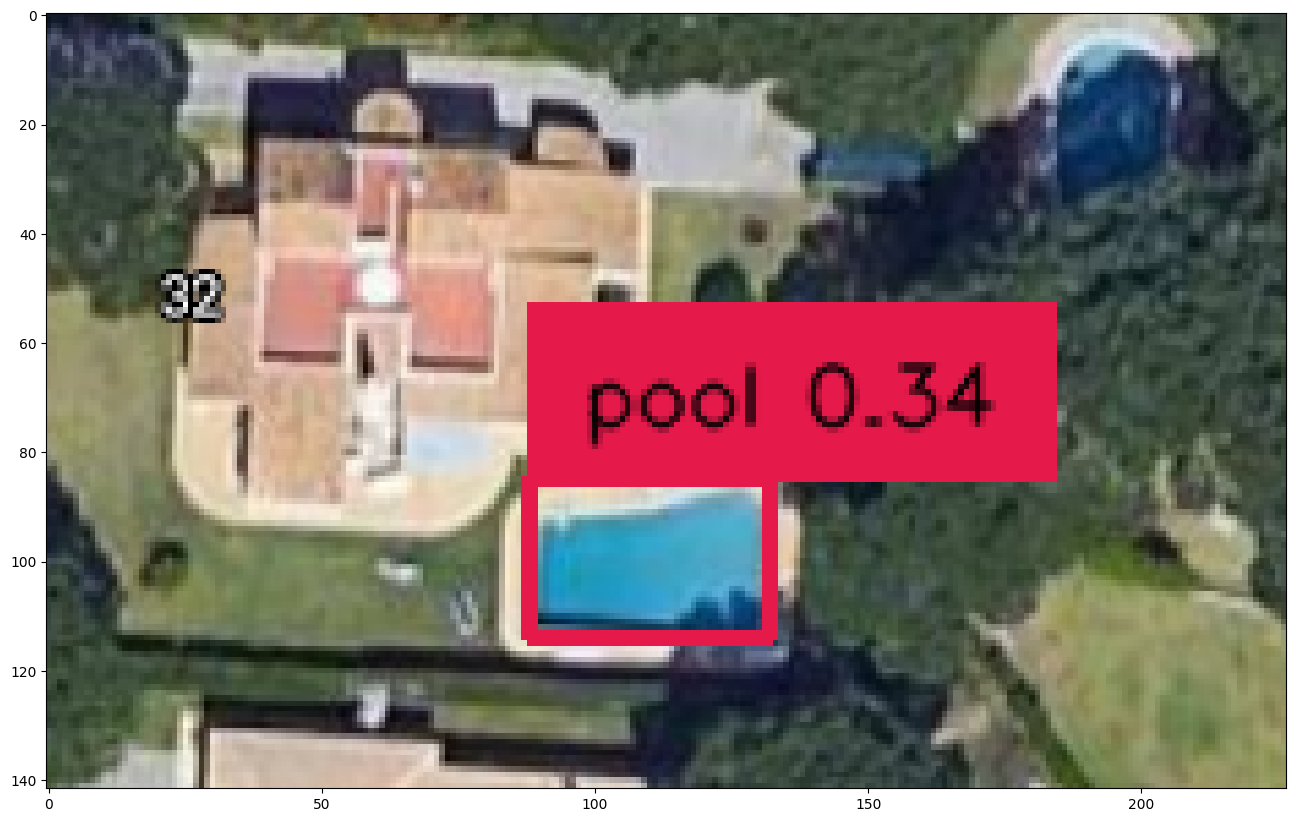

In [6]:
import cv2
import supervision as sv
import os

# Hardcoded image and detection parameters
SOURCE_IMAGE_PATH = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\images\89.PNG"
CLASSES = ['pool']
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

# Load image
image = cv2.imread(SOURCE_IMAGE_PATH)
caption = ", ".join(CLASSES)

# Run inference
detections, labels = model.predict_with_caption(
    image=image,
    caption=caption,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# Annotate results
box_annotator = sv.BoxAnnotator()
labels = [
    f"{label} {confidence:0.2f}"
    for label, (_, confidence, class_id, _)
    in zip(labels, detections)
]
annotated_frame = box_annotator.annotate(
    scene=image.copy(),
    detections=detections,
    labels=labels
)

# Display annotated image
sv.plot_image(annotated_frame, (16, 16))


### Classes Inference Mode
---
**NOTE:** You pass list of classes as a argument. Phrases returned by the model during prediction are treated as categories. For this reason, BoxAnnotator produces paint boxes with the same associated categories with the same color.

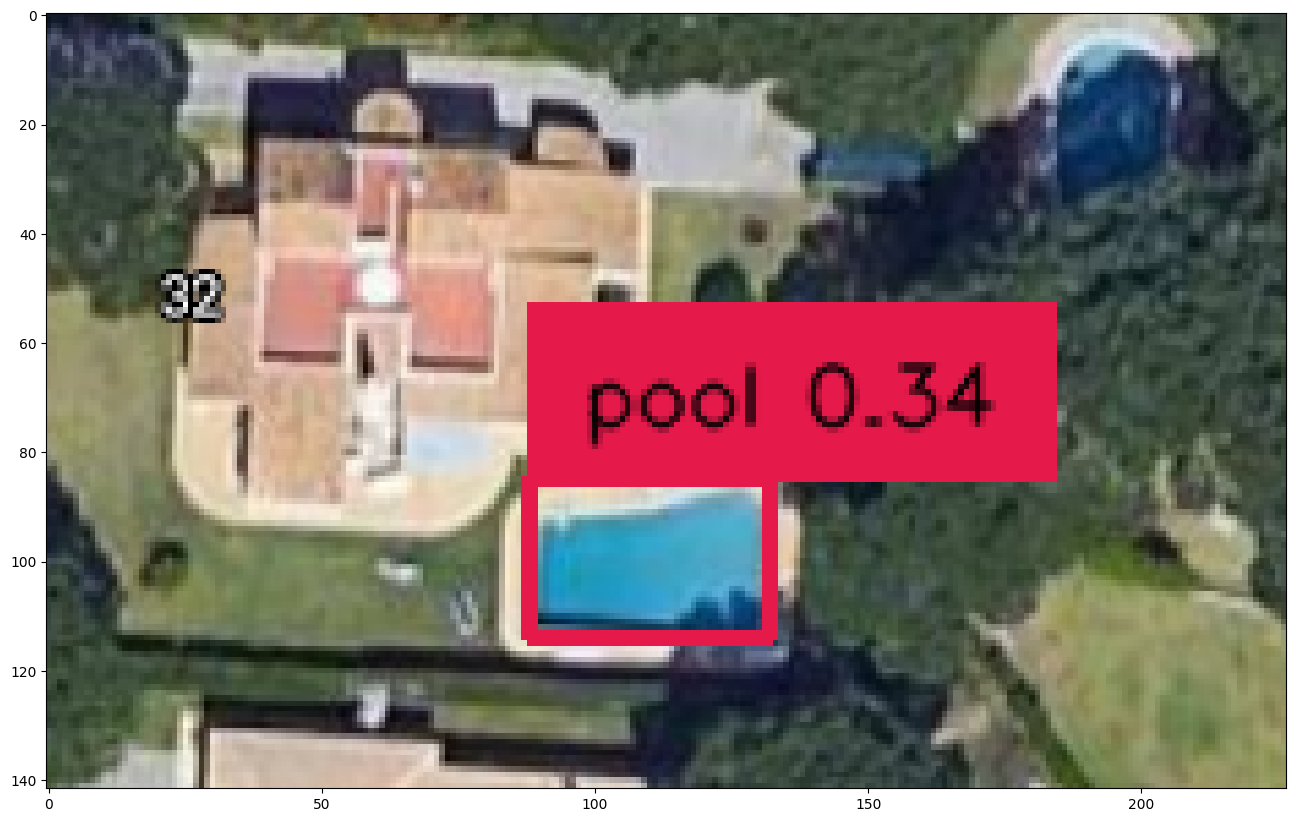

In [7]:
import cv2

import supervision as sv


image = cv2.imread(SOURCE_IMAGE_PATH)

detections = model.predict_with_classes(
    image=image,
    classes=CLASSES,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

### Enhanced Classes Inference Mode
---
**NOTE:** You pass list of classes as a argument. Those classes are enhenced using prompt engineering to ensure better result. Phrases returned by the model during prediction are treated as categories. For this reason, BoxAnnotator produces paint boxes with the same associated categories with the same color.

In [8]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

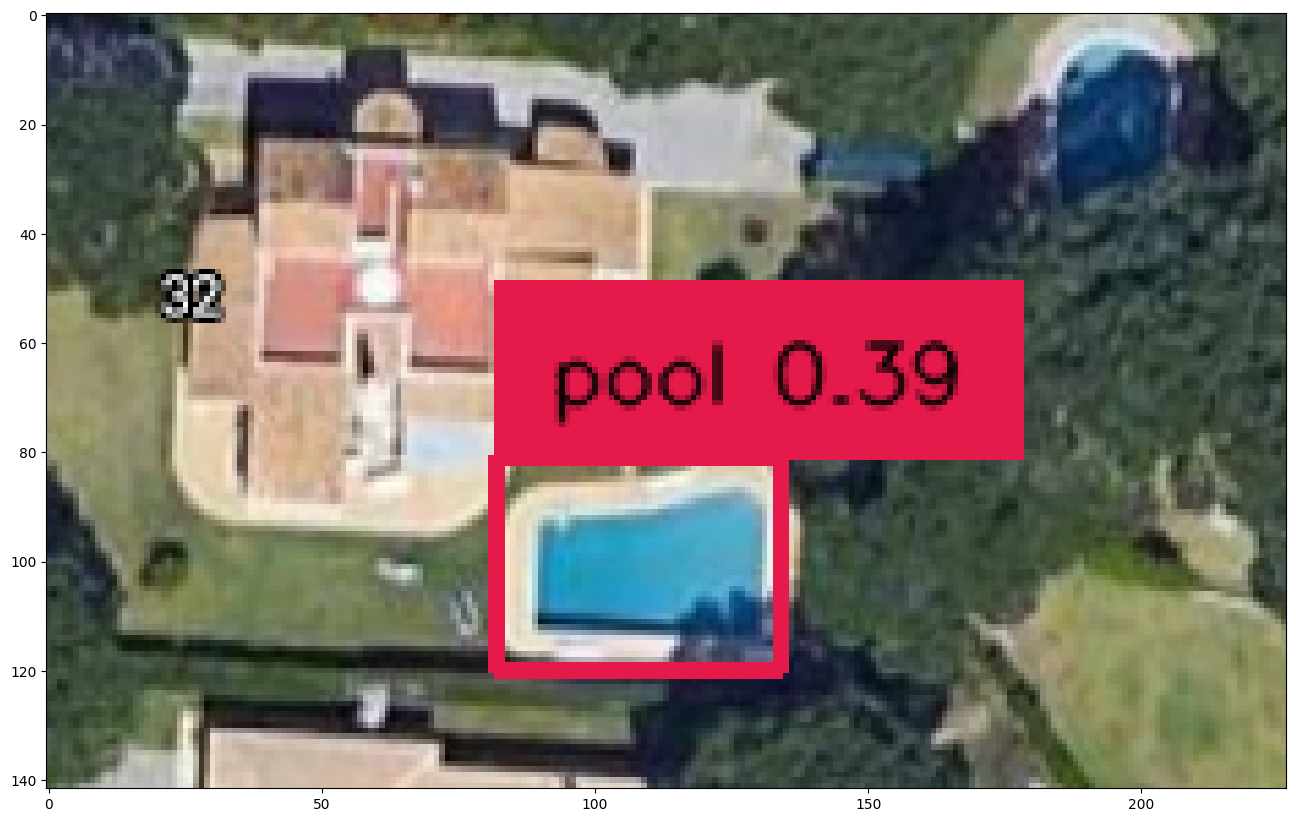

In [9]:
import cv2

import supervision as sv


image = cv2.imread(SOURCE_IMAGE_PATH)

detections = model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

**NOTE:** We can see that the quality of detection has improved. In particular, when it comes to the `chair` class.

## Utils Supporting Dataset Processing

A couple of helper functions that, unfortunately, we have to write ourselves to facilitate the processing of COCO annotations.

In [14]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections
import matplotlib.pyplot as plt


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

## Download Dataset from Roboflow

In order to evaluate how Grounding DINO handles zero-shot detection on custom datasets, we need to have labeled data. To do this, we download the data set in `COCO` format from Roboflow. In order to give you even more fun, we have selected for you several data sets with different levels of difficulty. Grounding DINO obtains mAPs on them from `1.0` to almost `0.0`.

In [ ]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

# candies mAP = 1.0
project = rf.workspace("roboflow-jvuqo").project("chocolate-candy")
dataset = project.version(3).download("coco")

# termal mAP = 0.42
# project = rf.workspace("antor-abir").project("thermal-dogs-and-people-pn8xg")
# dataset = project.version(1).download("coco")

# flowers mAP = 0.08
# project = rf.workspace("plantrecognition-kd7na").project("plant-recognition-wbhud")
# dataset = project.version(2).download("coco")

# aquarium mAP = 0.17
# project = rf.workspace("brad-dwyer").project("aquarium-combined")
# dataset = project.version(5).download("coco")

In [2]:
import os
from dotenv import load_dotenv
from roboflow import Roboflow

# Load API key
load_dotenv()
api_key = os.getenv("ROBOFLOW_API_KEY")

if not api_key:
    raise ValueError("❌ ROBOFLOW_API_KEY not found in .env")

# Log in and download dataset (no custom path)
rf = Roboflow(api_key=api_key)
project = rf.workspace("roboflow-jvuqo").project("chocolate-candy")
dataset = project.version(3).download("coco")

# Show where it actually went
print("✅ Dataset downloaded to:", dataset.location)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to chocolate-candy-3 in coco:: 100%|██████████| 28/28 [00:00<00:00, 1275.71it/s]

✅ Dataset downloaded to: c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\chocolate-candy-3


In [ ]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [3]:
import os

# Optional: fallback if dataset.location is not trustworthy
DEFAULT_DATASET_PATH = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\data\chocolate-candy-3"

# Use dataset.location if it exists and is valid, else fallback
dataset_dir = dataset.location if os.path.isdir(dataset.location) else DEFAULT_DATASET_PATH

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

# Construct full paths
IMAGES_DIRECTORY_PATH = os.path.join(dataset_dir, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, ANNOTATIONS_FILE_NAME)

# Print for verification
print("Images directory:", IMAGES_DIRECTORY_PATH)
print("Annotations file:", ANNOTATIONS_FILE_PATH)
print("Image folder exists:", os.path.isdir(IMAGES_DIRECTORY_PATH))
print("Annotations file exists:", os.path.isfile(ANNOTATIONS_FILE_PATH))

Images directory: C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\data\chocolate-candy-3\test
Annotations file: C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\data\chocolate-candy-3\test\_annotations.coco.json
Image folder exists: True
Annotations file exists: True


In [6]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

## Single Image Human vs. Zero-Shot Annotation

In this section, we compare the results of inference performed with Grounding DINO with manual annotations. We will choose one random image and then draw side by side automated and manual annotations.  

In [7]:
# set random seed to allow easy reproduction of the experiment

import random
random.seed(10)

**NOTE:** Execute this cell below 👇 once again to select a new random image, run inference with Grounding DINO and compare annotations with predictions.

In [ ]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations and image
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

image = cv2.imread(EXAMPLE_IMAGE_PATH)
h, w, _ = image.shape

# initiate annotator
box_annotator = sv.BoxAnnotator()

# annotate image with ground truth
labels = [
    f"{CLASSES[class_id]}"
    for _, _, class_id, _
    in ground_truth]
annotated_frame_ground_truth = box_annotator.annotate(
    scene=image.copy(), detections=ground_truth, labels=labels)

# run model and annotate image with detections
detections = model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# drop potential detections with phrase that is not part of CLASSES set
detections = detections[detections.class_id != None]
# drop potential detections with area close to area of whole image
detections = detections[(detections.area / (h * w)) < 0.9 ]
# drop potential double detections
detections = detections.with_nms()

labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(
    scene=image.copy(), detections=detections, labels=labels)


%matplotlib inline
sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_frame],
    grid_size=(1, 2),
    titles=["human annotation", "zero-shot annotation"]
)

In [9]:
classes = ["a photo of a chocolate", "a photo of a truffle", "a photo of candy"]

In [10]:
import os
import random
import cv2
import numpy as np
from supervision import Detections, BoxAnnotator, plot_images_grid

# --- Utility functions (no supervision.tools needed) ---

def get_annotations_by_image_path(coco_data, image_path):
    image_id = next((img.id for img in coco_data.images if img.file_name == image_path), None)
    return [ann for ann in coco_data.annotations if ann.image_id == image_id]

def annotations2detections(annotations):
    xyxy = []
    confidences = []
    class_ids = []
    for ann in annotations:
        x, y, w, h = ann.bbox
        xyxy.append([x, y, x + w, y + h])
        confidences.append(1.0)
        class_ids.append(ann.category_id)
    return Detections(
        xyxy=np.array(xyxy, dtype=np.float32),
        confidence=np.array(confidences, dtype=np.float32),
        class_id=np.array(class_ids, dtype=int)
    )

def enhance_class_name(class_names):
    return [f"a photo of a {name}" for name in class_names]

# --- Inference and Visualization ---

# Set up paths
DATA_SET_SUBDIRECTORY = "test"
dataset_dir = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\data\chocolate-candy-3"
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset_dir, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# Load image and ground truth annotations
image = cv2.imread(EXAMPLE_IMAGE_PATH)
h, w, _ = image.shape

annotations = get_annotations_by_image_path(coco_data, EXAMPLE_IMAGE_NAME)
ground_truth = annotations2detections(annotations)
ground_truth.class_id = ground_truth.class_id - 1  # shift COCO index

# Annotate ground truth
box_annotator = BoxAnnotator()
labels_gt = [f"{CLASSES[class_id]}" for _, _, class_id, _ in ground_truth]
annotated_frame_ground_truth = box_annotator.annotate(
    scene=image.copy(), detections=ground_truth, labels=labels_gt
)

# 🔍 Prompt override: more descriptive text helps
custom_prompt = ["chocolate", "a photo of candy", "a photo of truffle"]

# Run GroundingDINO prediction
detections = model.predict_with_classes(
    image=image,
    classes=custom_prompt,
    box_threshold=0.2,
    text_threshold=0.2
)

print("✅ Detections found:", len(detections))

# Postprocessing (optional — comment out to debug raw output)
#detections = detections[detections.class_id != None]
#detections = detections[(detections.area / (h * w)) < 0.9]
#detections = detections.with_nms()

# No filtering: show all raw detections
print("✅ Raw detections found:", len(detections))
print("Class IDs:", detections.class_id[:5])
print("Boxes:", detections.xyxy[:5])

# Annotate model predictions
labels_pred = []
for _, confidence, class_id, _ in detections:
    if isinstance(class_id, int) and class_id < len(custom_prompt):
        label = f"{custom_prompt[class_id]} {confidence:0.2f}"
    else:
        label = f"unknown {confidence:0.2f}"
    labels_pred.append(label)

# Show side-by-side
plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_frame_pred],
    grid_size=(1, 2),
    titles=["Human Annotation", "Zero-shot Prediction"]
)

ValueError: too many values to unpack (expected 4)

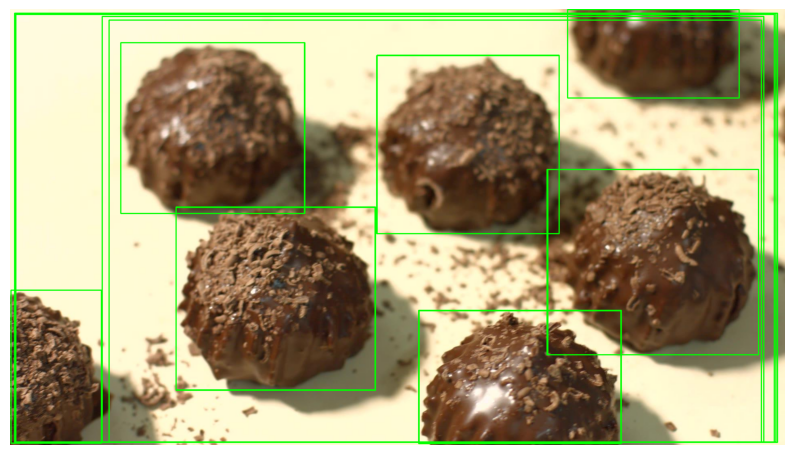

In [47]:
for box in detections.xyxy:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## Dataset Evaluation

In this section, we compare the results obtained with the Grounding DINO model and manual annotations at the whole-dataset level. We will also calculate key metrics like mAP and confusion matrix.

In [ ]:
from tqdm.notebook import tqdm


ground_true_batches, detections_batches = [], []

for image in tqdm(coco_data.images):
    image_name = image.file_name
    image_path = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, image_name)
    annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=image_name)
    try:
        ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)
    except:
        ground_truth = Detections(
            xyxy=np.empty((0, 4), dtype=np.float32),
            confidence=np.array([], dtype=np.float32),
            class_id=np.array([], dtype=int)
        )

    # small hack - coco numerate classes from 1, model from 0
    ground_truth.class_id = ground_truth.class_id - 1

    ground_true_batch = np.column_stack((
        ground_truth.xyxy,
        ground_truth.class_id
    ))
    image = cv2.imread(image_path)
    detections = model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # drop potential detections with phrase that is not part of CLASSES set
    detections = detections[detections.class_id != None]
    # drop potential detections with area close to area of whole image
    detections = detections[(detections.area / (h * w)) < 0.9 ]
    # drop potential double detections
    detections = detections.with_nms()

    detections_batch = np.column_stack((
        detections.xyxy,
        detections.class_id,
        detections.confidence
    ))
    ground_true_batches.append(ground_true_batch)
    detections_batches.append(detections_batch)

In [11]:
from tqdm import tqdm
import numpy as np
import cv2

ground_true_batches, detections_batches = [], []

for image in tqdm(coco_data.images):
    image_name = image.file_name
    image_path = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, image_name)
    
    # Load annotations (if fail, create empty)
    annotations = COCOJsonUtility.get_annotations_by_image_path(
        coco_data=coco_data,
        image_path=image_name
    )
    try:
        ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)
    except:
        ground_truth = Detections(
            xyxy=np.empty((0, 4), dtype=np.float32),
            confidence=np.array([], dtype=np.float32),
            class_id=np.array([], dtype=int)
        )
    
    ground_truth.class_id = ground_truth.class_id - 1  # shift class IDs

    ground_true_batch = np.column_stack((
        ground_truth.xyxy,
        ground_truth.class_id
    ))

    # Load image
    image = cv2.imread(image_path)

    # Skip if image failed to load
    if image is None:
        print(f"⚠️ Failed to load image: {image_path}")
        continue

    h, w, _ = image.shape

    # Inference
    detections = model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # TEMP: disable all filters to inspect detections
    # If needed, re-enable gradually
    # detections = detections[detections.class_id != None]
    # detections = detections[(detections.area / (h * w)) < 0.9]
    # detections = detections.with_nms()

    detections_batch = np.column_stack((
        detections.xyxy,
        detections.class_id if detections.class_id is not None else np.zeros(len(detections), dtype=int),
        detections.confidence
    ))

    ground_true_batches.append(ground_true_batch)
    detections_batches.append(detections_batch)

100%|██████████| 2/2 [00:00<00:00, 1721.09it/s]

⚠️ Failed to load image: c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\chocolate-candy-3\test\2-6_jpg.rf.072955e6a66e3ea650fa1115717bd1d8.jpg
⚠️ Failed to load image: c:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\references\chocolate-candy-3\test\2-5_jpg.rf.9c7d88b50960593fda41884b9decfabf.jpg


In [ ]:
from tqdm import tqdm
import os
import numpy as np
import cv2
from supervision import Detections
# Manually fix dataset path
dataset.location = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN\GroundingDINO\data\chocolate-candy-3"


# Prepare data structures
ground_true_batches, detections_batches = [], []

# Directory of test images
image_dir = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
actual_filenames = set(os.listdir(image_dir))

for image in tqdm(coco_data.images):
    original_file_name = image.file_name

    # Handle mismatched filenames (Roboflow renaming issue)
    if original_file_name not in actual_filenames:
        # Try matching by prefix (e.g., '2-6_jpg' → '2-6.jpg')
        base_prefix = original_file_name.split("_")[0]
        possible_match = next((f for f in actual_filenames if f.startswith(base_prefix)), None)
        if possible_match:
            image_name = possible_match
        else:
            print(f"❌ No matching image found for: {original_file_name}")
            continue
    else:
        image_name = original_file_name

    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)

    if image is None:
        print(f"⚠️ Failed to load image: {image_path}")
        continue

    h, w, _ = image.shape

    # Load ground truth annotations
    annotations = get_annotations_by_image_path(coco_data=coco_data, image_path=original_file_name)
    try:
        ground_truth = annotations2detections(annotations)
    except:
        ground_truth = Detections(
            xyxy=np.empty((0, 4), dtype=np.float32),
            confidence=np.array([], dtype=np.float32),
            class_id=np.array([], dtype=int)
        )

    ground_truth.class_id = ground_truth.class_id - 1  # Shift COCO indexing
    ground_true_batch = np.column_stack((ground_truth.xyxy, ground_truth.class_id))

    # Inference
    detections = model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # TEMP: skip filtering
    # detections = detections[detections.class_id != None]
    # detections = detections[(detections.area / (h * w)) < 0.9]
    # detections = detections.with_nms()

    # Handle missing class_ids
    if detections.class_id is None:
        class_ids = np.zeros((len(detections),), dtype=int)
    else:
        class_ids = detections.class_id

    detections_batch = np.column_stack((detections.xyxy, class_ids, detections.confidence))

    ground_true_batches.append(ground_true_batch)
    detections_batches.append(detections_batch)

In [58]:
from onemetric.cv.object_detection import MeanAveragePrecision
from onemetric.cv.object_detection import ConfusionMatrix

In [59]:
mean_average_precision = MeanAveragePrecision.from_detections(
    true_batches=ground_true_batches,
    detection_batches=detections_batches,
    num_classes=len(CLASSES),
    iou_threshold=0.5
)

print("mAP =", mean_average_precision.value)

mAP = 0.0


In [ ]:
confusion_matrix = ConfusionMatrix.from_detections(
    true_batches=ground_true_batches,
    detection_batches=detections_batches,
    num_classes=len(CLASSES),
    conf_threshold=BOX_TRESHOLD
)

In [ ]:
confusion_matrix.plot(os.path.join(HOME, "confusion_matrix.png"), class_names=CLASSES)

## Dataset auto annotation

In [15]:
import os


def list_image_files(directory: str) -> List[str]:
    image_extensions = [".jpeg", ".jpg", ".png", ".bmp", ".gif"]
    image_files = [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]
    return image_files


def save_voc_xml(xml_string: str, file_path: str) -> None:
    with open(file_path, 'w') as f:
        f.write(xml_string)


def image_name_to_xml_name(image_name: str) -> str:
    base_name, _ = os.path.splitext(image_name)
    xml_name = f"{base_name}.xml"
    return xml_name

In [19]:
import os
import random
import cv2
import numpy as np
from supervision import Detections, BoxAnnotator, plot_images_grid

# --- Utility functions (no supervision.tools needed) ---

def get_annotations_by_image_path(coco_data, image_path):
    image_id = next((img.id for img in coco_data.images if img.file_name == image_path), None)
    return [ann for ann in coco_data.annotations if ann.image_id == image_id]

def annotations2detections(annotations):
    xyxy = []
    confidences = []
    class_ids = []
    for ann in annotations:
        x, y, w, h = ann.bbox
        xyxy.append([x, y, x + w, y + h])
        confidences.append(1.0)
        class_ids.append(ann.category_id)
    return Detections(
        xyxy=np.array(xyxy, dtype=np.float32),
        confidence=np.array(confidences, dtype=np.float32),
        class_id=np.array(class_ids, dtype=int)
    )

def enhance_class_name(class_names):
    return [f"a photo of a {name}" for name in class_names]

### Create empty Roboflow project

In [6]:
import os

HOME = r"C:\Users\SABIO\Documents\GitHub\Pool-Detection-CNN"

PROJECT_NAME = "Pool-Detect-CNN"
PROJECT_DESCRIPTION = "Detect-pools-in-satelite-images"
SOURCE_DIRECTORY_PATH = os.path.join(HOME, "images")
CLASSES = ['pool']
BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.25

In [7]:
from roboflow import Roboflow

workspace = Roboflow().workspace()
new_project = workspace.create_project(
    project_name=PROJECT_NAME,
    project_license="MIT",
    project_type="object-detection",
    annotation=PROJECT_DESCRIPTION)

loading Roboflow workspace...
loading Roboflow project...


### Detect and Upload Annotations to New Project

Finally, how about putting Grounding DINO in front of a real test and using it to automatically annotate datasets. Labels will be sent to Roboflow where you can manually review them.

In [21]:
from os import listdir
import cv2
import supervision as sv


for image_name in list_image_files(SOURCE_DIRECTORY_PATH):
    image_path = os.path.join(SOURCE_DIRECTORY_PATH, image_name)
    image = cv2.imread(image_path)
    height, width, depth = image.shape
    xml_name = image_name_to_xml_name(image_name=image_name)
    xml_path = os.path.join(SOURCE_DIRECTORY_PATH, xml_name)

    detections = model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    # drop potential detections with phrase that is not part of CLASSES set
    detections = detections[detections.class_id != None]
    # drop potential detections with area close to area of whole image
    detections = detections[(detections.area / (height * width)) < 0.9 ]
    # drop potential double detections
    # detections = detections.with_nms()

    xml_string = sv.detections_to_voc_xml(
        detections=detections,
        classes=CLASSES,
        filename=image_name,
        width=width,
        height=height,
        depth=depth
    )

    save_voc_xml(xml_string=xml_string, file_path=xml_path)
    new_project.upload(image_path=image_path, annotation_path=xml_path, split="train", overwrite=True)

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.